In [1]:
import terrapyn as tp
import pandas as pd
import xarray as xr
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

/Users/chill/software/anaconda3/envs/dev/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# SPI

SPI is normally calculated for each month the year, grouping together the same month across all years. These monthly values are typically the rolling mean over a given period: 3, 6, 12, 24, 48 months. The choice of the number of months over which to calculate a rolling mean is related to the phenomena/timescale of interest, where 3 month SPI is used for a short-term or seasonal drought index, 12 month SPI for an intermediate-term drought index, and 48 month SPI for a long-term drought index.


### Note:
* Data should have monthly timesteps. If the timesteps have a frequency higher than monthly, the data should be resampled to monthly timesteps.
* SPI is calculated separately for each month, where a Gamma distribution is fit to all values for that month for all years. , then perform the gamma -to-normal transformation.
* The result should have monthly timesteps
* There should be the ability to output the gamma alpha and beta coeff, and a way to use these coeff with new data to calculate SPI for the new data - i.e. we calculate alpha and beta for the reference data, then the new data is compared to this distribution, the probability value transformed from gamma to normal, and the SPI obtained


### Example to show the fit of a Gamma PDF

In [2]:
orig_shape = 2
orig_scale = 1
orig_loc = 0
n_values = 50
values = st.gamma.rvs(orig_shape, orig_loc, orig_scale, size=n_values, random_state=123)

Let's plot the data

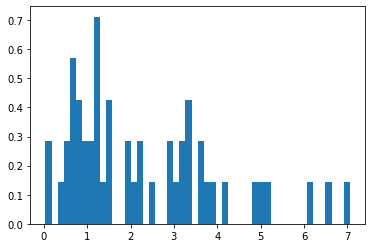

In [3]:
_ = plt.hist(values, bins=50, density=True, align='mid');

* To calculate SPI, we need to determine the probability density function of the data, so we can convert it to the Normal probability density function.
* We can do this by fitting a Gamma Probability Distribution Function (PDF) to the values.
    - For a Gamma function, the `shape` and `scale` parameters are required to define the PDF.

In [4]:
# Fit the Gamma PDF
shape, scale = tp.indices.spi._fit_gamma_pdf(values)
shape, scale 

(1.5145710411084323, 1.5116993002982584)

Now lets plot the original data with the fitted Gamma PDF

In [5]:
def plot_pdf(values, shape, scale, orig_shape=None, orig_scale=None):
    xi = np.linspace(values.min(), values.max(), 1000)
    pdf = st.gamma.pdf(xi, a=shape, loc=0, scale=scale)
    plt.hist(values, bins=50, density=True, align='mid')
    plt.plot(xi, pdf, label='fitted', lw=2, color='red');    

    if all([orig_shape, orig_loc, orig_scale]):
        orig_pdf = st.gamma.pdf(xi, a=orig_shape, loc=0, scale=orig_scale)
        plt.plot(xi, orig_pdf, label='original', color='k', lw=2);
    plt.legend();

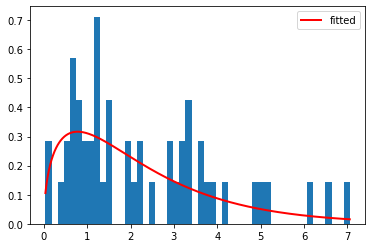

In [6]:
plot_pdf(values, shape, scale, orig_shape, orig_scale)

With the Gamma PDF defined, we can easily calculate the Gamma Cumulative Distribution Function (CDF). This is how we will transform the Gamma distribution into the Normal distribution.

In [7]:
prob_zero = np.sum(values == 0) / values.shape[0]  # Fraction of zero values
sorted_values = np.sort(values)
values_cum_prob = np.linspace(0, 1, sorted_values.shape[0])
fitted_xi = np.linspace(sorted_values[0], sorted_values[-1], n_values)
fitted_cdf = prob_zero + (1 - prob_zero) * st.gamma.cdf(fitted_xi, a=shape, loc=0, scale=scale)

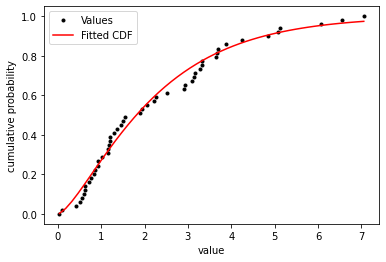

In [8]:
plt.plot(sorted_values, values_cum_prob, label='Values', color='k', ls='none', marker='.');
plt.plot(fitted_xi, fitted_cdf, label='Fitted CDF', color='red');
plt.xlabel('value');
plt.ylabel('cumulative probability');
plt.legend();

In [9]:
# Empiracal cumulative prob func
# Kth value is k-1 from the lowest, n is sample size
# emp cum prob = k / (n + 1)
# k = 1,2,3...

# TODO only count non-nan
n = values.shape[0]

prob_zero = np.sum(values == 0) / n  # Fraction of zero values

sorted_values = np.sort(values)
cum_prob = np.linspace(0, 1, sorted_values.shape[0])
fitted_xi = np.linspace(sorted_values[0], sorted_values[-1], n_values)
fitted_cdf = prob_zero + (1 - prob_zero) * st.gamma.cdf(fitted_xi, a=shape, loc=0, scale=scale)

In [10]:
# Calculate the CDF for the values using the fitted parameters
gamma_cdf = tp.indices.spi._calc_gamma_cdf(values, shape=shape, scale=scale)

In [11]:
# Apply the inverse normal distribution to the cdf
normal_ppf = tp.indices.spi.cdf_to_normal_ppf(pd.Series(gamma_cdf))

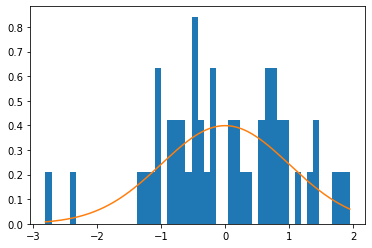

In [12]:
norm_xi = np.linspace(normal_ppf.min(), normal_ppf.max(), 1000)
norm_pdf = st.norm.pdf(norm_xi, loc=0, scale=1)
_ = plt.hist(normal_ppf, bins=50, density=True)
plt.plot(norm_xi, norm_pdf);

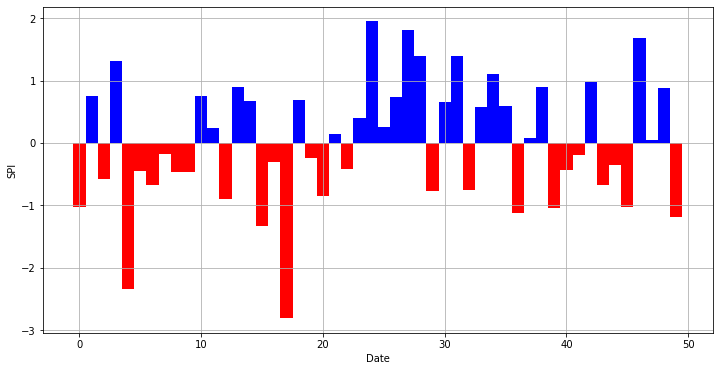

In [13]:
neg_index = normal_ppf < 0
pos_index = ~neg_index

x = np.arange(0, normal_ppf.shape[0])

bin_width = 1

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x[pos_index], normal_ppf[pos_index], width=bin_width, align='center', color='b')
ax.bar(x[neg_index], normal_ppf[neg_index], width=bin_width, align='center', color='r')
ax.grid(True)
ax.set_xlabel("Date");
ax.set_ylabel("SPI");

# Monthly SPI

SPI is normally calculated for each month the year, grouping together the same month across all years. These monthly values are typically the rolling mean over a given period: 3, 6, 12, 24, 48 months. The choice of the number of months over which to calculate a rolling mean is related to the phenomena/timescale of interest, where 3 month SPI is used for a short-term or seasonal drought index, 12 month SPI for an intermediate-term drought index, and 48 month SPI for a long-term drought index.


## Generate test data
* Data that follows a Gamma distribution and could represent daily/monthly precipitation over many years

In [14]:
orig_shape = 2
orig_scale = 1
orig_loc = 0  # This should always be 0 for precipitation
n_values = 12 * 70  # 70 years of monthly data
values = np.array(
    [
        st.gamma.rvs(orig_shape, orig_loc, orig_scale, size=n_values, random_state=random_state)
        for random_state in [123, 42, 3, 14]
    ]
).reshape(2, 2, n_values)

da = xr.DataArray(
    values,
    coords={"lat": [1, 2], "lon": [3, 4], "time": pd.date_range("1950-01-01", periods=n_values, freq="MS")},
    name="tp",
)
series = da.isel(lon=0, lat=0).to_series()

In [15]:
n_months = 3
time_dim = "time"

In [16]:
spi, gamma_parameters = tp.indices.spi.calc_spi(da, return_gamma_params=True)

In [17]:
# spi = tp.indices.spi.calc_spi(da, gamma_parameters=gamma_parameters)

In [18]:
point = spi.isel(lat=0, lon=0)

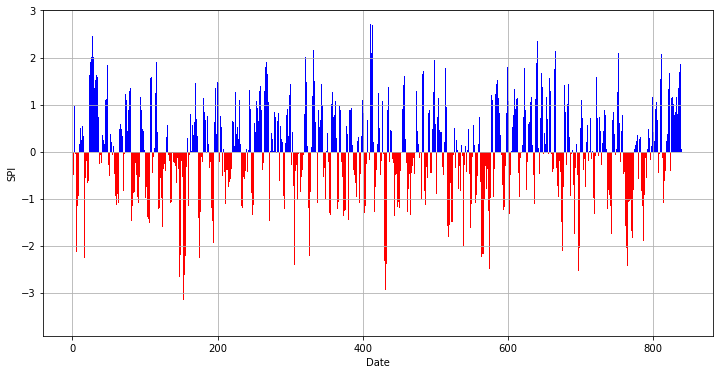

In [19]:
neg_index = point.values < 0
pos_index = ~neg_index

bin_width = 1

x = np.arange(len(point['time'].values))
# x = point.time.values

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(
    # point['time'][pos_index].values.astype(dt.datetime),
    x[pos_index],
    height=point[pos_index].values, width=bin_width, align='center', color='b')
ax.bar(
    x[neg_index],
    # point['time'][neg_index].values,
     height=point[neg_index].values, width=bin_width, align='center', color='r')
ax.grid(True)
ax.set_xlabel("Date");
ax.set_ylabel("SPI");

## Simple example including all data

This is conceptually wrong, since we should group by month. However, it demonstrates each step in the process.

* First fit the Gamma PDF to the data

In [20]:
gamma_parameters = tp.indices.spi.fit_gamma_pdf(da)
gamma_parameters

<xarray.Dataset>
Dimensions:  (lat: 2, lon: 2)
Coordinates:
  * lat      (lat) int64 1 2
  * lon      (lon) int64 3 4
Data variables:
    shape    (lat, lon) float32 2.105 2.151 1.951 1.855
    scale    (lat, lon) float32 0.9652 0.942 1.004 1.048

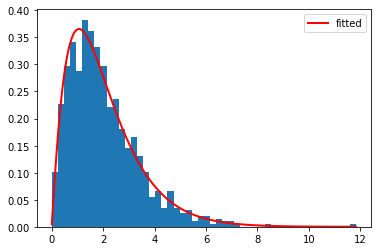

In [21]:
plot_pdf(
    da.isel(lat=0, lon=0),
    gamma_parameters['shape'].isel(lat=0, lon=0),
    gamma_parameters['scale'].isel(lat=0, lon=0)
)

Next calculate the Gamma CDF for the data

In [22]:
gamma_cdf = tp.indices.spi.calc_gamma_cdf(da, gamma_parameters)
# gamma_cdf

Finally, transform the Gamma CDF to a Normal PPF

In [23]:
normal_ppf = tp.indices.spi.cdf_to_normal_ppf(gamma_cdf)
# normal_ppf

These values are in units of `std` of the zero-centered Normal distribution. We can plot all the values to show where each transformed value lies in the distribution of all values.

In [24]:
# Select one coordinate
point = normal_ppf.isel(lat=0, lon=0)

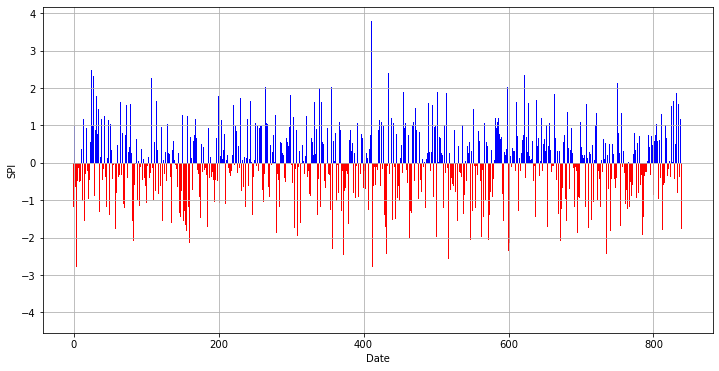

In [25]:
neg_index = point < 0
pos_index = ~neg_index

x = np.arange(len(point['time'].values))

bin_width = 1

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(
    # point['time'][pos_index].values,
    x[pos_index],
     height=point[pos_index].values, width=bin_width, align='center', color='b')
ax.bar(x[neg_index]
# point['time'][neg_index].values
, height=point[neg_index].values, width=bin_width, align='center', color='r')
ax.grid(True)
ax.set_xlabel("Date");
ax.set_ylabel("SPI");